In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer

/Users/junaid.shaikh/Desktop/Personal/sentiment-detection/sentx/.env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


# Create and store vector embeddings

In [9]:
df = pd.read_csv("../data/train_data-v1.csv")

In [11]:
df.head()

,index,label,tweet,updated_label
0,501532,0,.what the hell is happening...,0
1,609271,0,"I know, I would have , but space is tight here...",0
2,395691,0,i think i may have lost a friend,0
3,341582,0,if fed up with the NSW v QLD game,0
4,12308,0,Sudbury's never gonna win,0


In [13]:
model = SentenceTransformer("thenlper/gte-base")

/Users/junaid.shaikh/Desktop/Personal/sentiment-detection/sentx/.env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [22]:
embeddings = []
batch_size = 100
num_batches = df.shape[0]//batch_size

for idx in range(num_batches):
    batch = df.iloc[idx*batch_size:batch_size*(idx+1)]
    sentences = batch["tweet"].to_list()
    emb = model.encode(sentences)
    embeddings.append(emb)
    print(f"done batch {idx}/{num_batches}")

done batch 0/2400
done batch 1/2400
done batch 2/2400
done batch 3/2400
done batch 4/2400
done batch 5/2400
done batch 6/2400
done batch 7/2400
done batch 8/2400
done batch 9/2400
done batch 10/2400
done batch 11/2400
done batch 12/2400
done batch 13/2400
done batch 14/2400
done batch 15/2400
done batch 16/2400
done batch 17/2400
done batch 18/2400
done batch 19/2400
done batch 20/2400
done batch 21/2400
done batch 22/2400
done batch 23/2400
done batch 24/2400
done batch 25/2400
done batch 26/2400
done batch 27/2400
done batch 28/2400
done batch 29/2400
done batch 30/2400
done batch 31/2400
done batch 32/2400
done batch 33/2400
done batch 34/2400
done batch 35/2400
done batch 36/2400
done batch 37/2400
done batch 38/2400
done batch 39/2400
done batch 40/2400
done batch 41/2400
done batch 42/2400
done batch 43/2400
done batch 44/2400
done batch 45/2400
done batch 46/2400
done batch 47/2400
done batch 48/2400
done batch 49/2400
done batch 50/2400
done batch 51/2400
done batch 52/2400
don

In [24]:
embeddings = np.vstack(embeddings)

In [26]:
np.save("../data/embeddings.npy", embeddings)

# Training SVM from embeddings

In [2]:
df = pd.read_csv("../data/train_data-v1.csv")
labels = df["updated_label"].to_numpy()
embeddings = np.load("../data/embeddings.npy")

In [3]:
from sklearn.model_selection import train_test_split

train_emb, test_emb, train_label, test_label = train_test_split(embeddings, labels, test_size=0.15, random_state=42)

In [4]:
print("Training samples: ",train_emb.shape[0])
print("Testing samples: ",test_emb.shape[0])

Training samples:  204000
Testing samples:  36000


In [57]:
from sklearn import svm

svc_classifier = svm.SVC(verbose=True, random_state=42, probability=True)

In [58]:
svc_classifier.fit(train_emb, train_label)

[LibSVM].....*..*
optimization finished, #iter = 7738
obj = -4180.222845, rho = 0.693799
nSV = 6566, nBSV = 5464
Total nSV = 6566
.....*..*
optimization finished, #iter = 7659
obj = -4247.882854, rho = 0.780328
nSV = 6611, nBSV = 5559
Total nSV = 6611
.....*..*
optimization finished, #iter = 7765
obj = -4216.244817, rho = 0.695010
nSV = 6599, nBSV = 5498
Total nSV = 6599
.....*..*
optimization finished, #iter = 7787
obj = -4224.717914, rho = 0.858313
nSV = 6614, nBSV = 5512
Total nSV = 6614
.....*..*
optimization finished, #iter = 7527
obj = -4224.130215, rho = 0.692529
nSV = 6586, nBSV = 5522
Total nSV = 6586
......*..*
optimization finished, #iter = 8759
obj = -4881.581992, rho = -0.820241
nSV = 7585, nBSV = 6365
......*.*
optimization finished, #iter = 7926
obj = -5400.729731, rho = 3.916449
nSV = 8004, nBSV = 7095
Total nSV = 8004
......*..*
optimization finished, #iter = 8013
obj = -5383.522383, rho = 3.681695
nSV = 8003, nBSV = 7068
Total nSV = 8003
......*..*
optimization finish

In [8]:
# svc_classifier.score(test_emb, test_label)

0.9896111111111111

In [9]:
preds = svc_classifier.predict(test_emb)

In [11]:
from sklearn.metrics import confusion_matrix, f1_score
confusion_matrix(test_label, preds)

array([[11737,    48,    90],
       [   49, 11748,   131],
       [   46,    10, 12141]])

In [13]:
f1_score(test_label, preds, average='micro')

np.float64(0.9896111111111111)

In [16]:
# persisting model
import pickle
with open("../models/sentiment-classifier-svc.pkl", "wb") as f:
    pickle.dump(svc_classifier, f)

In [25]:
sample = df.sample(n=20)
encoder = SentenceTransformer("thenlper/gte-base")

label_mapping = {
    0 : "negative",
    1 : "positive",
    2 : "neutral"
}

for _, row in sample.iterrows():
    s = row["tweet"]
    l = label_mapping[row["updated_label"]]
    emb = encoder.encode(s)
    pred = svc_classifier.predict(emb.reshape(1, -1))
    pl = label_mapping[pred[0]]

    print(f"{s} | pred: {pl} | actual: {l} ")
    

/Users/junaid.shaikh/Desktop/Personal/sentiment-detection/sentx/.env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Today is So not my lucky day... | pred: neutral | actual: neutral 
Hi Alison! Nice to Tweet you! Hope your Ohio weather was as beautiful today as our Michigan weather was! | pred: positive | actual: positive 
I couldn't tweet | pred: negative | actual: negative 
lol I did, but it was ok mostly because we were too busy to pretend to like each other ha. you were the lucky one this week | pred: positive | actual: positive 
want a new hair bands, maybe create one for herself | pred: positive | actual: positive 
I WANT A CAT! tried a dog, didnt work. so im setteling for a cat. still dont think itll work with mum and dad though | pred: negative | actual: negative 
i like this line &quot;knowing how much i try, stil come close to losing you girl&quot; waw. | pred: positive | actual: positive 
Yeh official jon and kate separating so sad | pred: negative | actual: negative 
is listening to Everything You Want by Vertical Horizon. Aww, miss old times | pred: positive | actual: positive 
Early lu

In [26]:
## benchmarking with testdata

In [29]:
df_test = pd.read_csv("../data/testdata.manual.2009.06.14.csv", names=["label", "id", "timestamp", "unk1", "user_id", "tweet"], encoding="utf-8", encoding_errors="ignore")

In [30]:
df_test.head()

,label,id,timestamp,unk1,user_id,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [32]:
import re

regex_url_matching = "https?://\S+|www.\S+"
regex_userid_matching = "@\S+"
regex_extra_spaces = "\s{2,}"
regex_hashtag = "#\S+"
regex_non_chars_line = "^[\W_]+$"

def clean_row(row):
    row = re.sub(regex_url_matching, ' ', row)
    row = re.sub(regex_userid_matching, ' ', row)
    row = re.sub(regex_hashtag, " ", row)
    row = re.sub(regex_non_chars_line, " ", row)
    row = re.sub(regex_extra_spaces, " ", row)
    row = row.strip()   

    if not row:
        return pd.NA
    
    return row

In [33]:
df_test["tweet"] = df_test["tweet"].apply(lambda x: clean_row(x))

In [34]:
df_test.head()

,label,id,timestamp,unk1,user_id,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,I loooooooovvvvvveee my Kindle2. Not that the ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,You'll love your Kindle2. I've had mine for a ...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,Fair enough. But i have the Kindle2 and I thin...


In [53]:
predicted_labels = []
actual_labels = []
batch_size = 100
num_batches = df_test.shape[0]//batch_size

train_label_mapping = {
    0 : "negative",
    1 : "positive",
    2 : "neutral"
}

test_label_mapping = {
    "negative" : 0,
    "neutral" : 2,
    "positive": 4,
}

def train2test_labels(labels):
    nlabels = []
    for l in labels:
        nlabels.append(test_label_mapping[train_label_mapping[l]])
    return nlabels


for idx in range(num_batches):
    batch = df_test.iloc[idx*batch_size:batch_size*(idx+1)]
    sentences = batch["tweet"].to_list()
    emb = encoder.encode(sentences)
    preds = svc_classifier.predict(emb)
    predicted_labels += train2test_labels(preds)
    actual_labels += batch["label"].to_list()

    # break
    print(f"done batch {idx}/{num_batches}")

done batch 0/4
done batch 1/4
done batch 2/4
done batch 3/4


In [54]:
f1_score(predicted_labels, actual_labels, average="weighted")

np.float64(0.6945188550501823)

In [55]:
confusion_matrix(predicted_labels, actual_labels)

array([[123,  18,  14],
       [ 20,   5,  11],
       [  7,  71, 131]])

In [56]:
for s, p, a in zip(sentences, predicted_labels, actual_labels):
    if a == 2:
        print(f"{s} | predict: {p} | actual: {a}")

New blog post: Nike Zoom LeBron Soldier 3 (III) - White / Black - Teal | predict: 4 | actual: 2
Listening to Obama... Friggin North Korea... | predict: 4 | actual: 2
I just realized we three monkeys in the white Obama.Biden,Pelosi . Sarah Palin 2012 | predict: 4 | actual: 2
obviously not siding with Cheney here: | predict: 4 | actual: 2
Absolutely hilarious!!! from | predict: 4 | actual: 2
I never did thank you for including me in your Top 100 Twitter Authors! You Rock! (&amp; I New Wave :-D) | predict: 2 | actual: 2
Goodby, Silverstein's new site... I enjoy it. | predict: 4 | actual: 2
Wow everyone at the Google I/O conference got free G2's with a month of unlimited service | predict: 4 | actual: 2
the G2 is amazing btw, a HUGE improvement over the G1 | predict: 4 | actual: 2
saw night at the museum out of sheer desperation. who is funding these movies? | predict: 4 | actual: 2
Watching Night at the Museum - giggling. | predict: 4 | actual: 2
So, Night at the Museum 2 was AWESOME! Muc

# Train Logistic Regression

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer

/Users/junaid.shaikh/Desktop/Personal/sentiment-detection/sentx/.env/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
df = pd.read_csv("../data/train_data-v1.csv")
labels = df["updated_label"].to_numpy()
embeddings = np.load("../data/embeddings.npy")

In [3]:
from sklearn.model_selection import train_test_split

train_emb, test_emb, train_label, test_label = train_test_split(embeddings, labels, test_size=0.15, random_state=42)

In [4]:
print("Training samples: ",train_emb.shape[0])
print("Testing samples: ",test_emb.shape[0])

Training samples:  204000
Testing samples:  36000


In [5]:
from sklearn.linear_model import LogisticRegression
lr_cls = LogisticRegression(verbose=True)

In [6]:
lr_cls.fit(train_emb, train_label)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         2307     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09861D+00    |proj g|=  4.19255D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
 2307     34     38      1     0     0   4.450D-05   9.687D-02
  F =   9.6871911534196498E-002

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


LogisticRegression(verbose=True)

In [7]:
res = lr_cls.predict(test_emb)

In [19]:
from sklearn.metrics import confusion_matrix, f1_score, ConfusionMatrixDisplay
confusion_matrix(res, test_label)

array([[11768,    39,    28],
       [   37, 11791,     4],
       [   70,    98, 12165]])

In [10]:
f1_score(res, test_label, average='micro')

np.float64(0.9923333333333333)

In [11]:
# testing on test data
df_test = pd.read_csv("../data/testdata.manual.2009.06.14.csv", names=["label", "id", "timestamp", "unk1", "user_id", "tweet"], encoding="utf-8", encoding_errors="ignore")


In [12]:
import re

regex_url_matching = "https?://\S+|www.\S+"
regex_userid_matching = "@\S+"
regex_extra_spaces = "\s{2,}"
regex_hashtag = "#\S+"
regex_non_chars_line = "^[\W_]+$"

def clean_row(row):
    row = re.sub(regex_url_matching, ' ', row)
    row = re.sub(regex_userid_matching, ' ', row)
    row = re.sub(regex_hashtag, " ", row)
    row = re.sub(regex_non_chars_line, " ", row)
    row = re.sub(regex_extra_spaces, " ", row)
    row = row.strip()   

    if not row:
        return pd.NA
    
    return row

In [13]:
df_test["tweet"] = df_test["tweet"].apply(lambda x: clean_row(x))

In [14]:
df_test.head()

,label,id,timestamp,unk1,user_id,tweet
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,I loooooooovvvvvveee my Kindle2. Not that the ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs is...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the ...it fucking rocks!!!"
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,You'll love your Kindle2. I've had mine for a ...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,Fair enough. But i have the Kindle2 and I thin...


In [15]:
sample = df.sample(n=20)
encoder = SentenceTransformer("thenlper/gte-base")

label_mapping = {
    0 : "negative",
    1 : "positive",
    2 : "neutral"
}

for _, row in sample.iterrows():
    s = row["tweet"]
    l = label_mapping[row["updated_label"]]
    emb = encoder.encode(s)
    pred = lr_cls.predict(emb.reshape(1, -1))
    pl = label_mapping[pred[0]]

    print(f"{s} | pred: {pl} | actual: {l} ")

/Users/junaid.shaikh/Desktop/Personal/sentiment-detection/sentx/.env/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


up at 4:06am in pain | pred: neutral | actual: neutral 
Thankyou!! How are you today? xxxx | pred: neutral | actual: neutral 
ha! yeah, that's true. but one brag a day is my limit Oh I wanted to ask about the cherry thing. is there a story there | pred: positive | actual: positive 
Pizza for breakfast i think. Then i might watch twilight x | pred: neutral | actual: neutral 
I had a great night. | pred: positive | actual: positive 
That's what I'll .......... probably .............. be doing too! | pred: positive | actual: positive 
morning! yes i wish they'd hide the peeps away that are waiting at the Paris airport its not right for them | pred: neutral | actual: neutral 
ooo last thing said was one day ago, im slipping up | pred: neutral | actual: neutral 
Sooo manual labor is HARD!! I'm not a painter! Ugh... I stop getting paid in 20 minutes but I'll probably be here another 2 hours! | pred: neutral | actual: neutral 
I can relate! Didn't know, then when I did my parents destroyed th

In [26]:
predicted_labels = []
actual_labels = []
batch_size = 100
num_batches = df_test.shape[0]//batch_size

train_label_mapping = {
    "negative": 0,
    "positive": 1,
    "neutral": 2
}

test_label_mapping = {
    0:"negative",
    2:"neutral",
    4:"positive",
}

# def train2test_labels(labels):
#     nlabels = []
#     for l in labels:
#         nlabels.append(test_label_mapping[train_label_mapping[l]])
#     return nlabels

def test2train_labels(labels):
    nlabels = []
    for l in labels:
        nlabels.append(train_label_mapping[test_label_mapping[l]])
    return nlabels


for idx in range(num_batches):
    batch = df_test.iloc[idx*batch_size:batch_size*(idx+1)]
    sentences = batch["tweet"].to_list()
    emb = encoder.encode(sentences)
    preds = lr_cls.predict(emb)
    predicted_labels += preds.tolist()
    actual_labels += test2train_labels(batch["label"].to_list())

    # break
    print(f"done batch {idx}/{num_batches}")

done batch 0/4
done batch 1/4
done batch 2/4
done batch 3/4


In [17]:
f1_score(predicted_labels, actual_labels, average="micro")

np.float64(0.645)

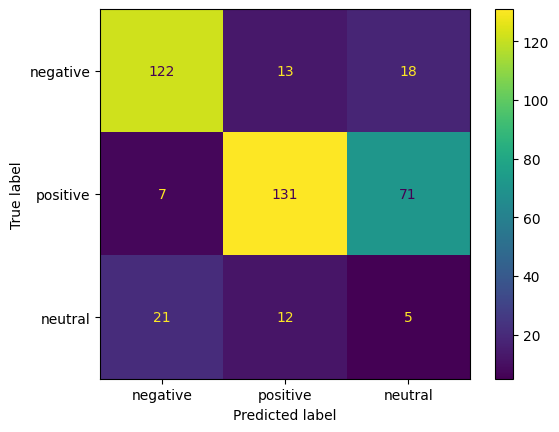

In [30]:
disp = ConfusionMatrixDisplay(confusion_matrix(predicted_labels, actual_labels, labels=lr_cls.classes_), display_labels=["negative", "positive", "neutral"])
disp.plot()